# Import

In [1]:
import os
import sys

proj_dir = "/home/scai/PhenPred"
if not os.path.exists(proj_dir):
    proj_dir = "/Users/emanuel/Projects/PhenPred"
sys.path.extend([proj_dir])

import json
import PhenPred
import argparse
import pandas as pd
from PhenPred.vae import plot_folder
from PhenPred.vae.Hypers import Hypers
from PhenPred.vae.Train import CLinesTrain
from PhenPred.vae.DatasetDepMap23Q2 import CLinesDatasetDepMap23Q2
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [2]:
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 4
plt.rcParams["axes.linewidth"] = 0.25
plt.rcParams["figure.figsize"] = (2.5, 2.5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.linewidth"] = 0.25
plt.rcParams["legend.fontsize"] = 4

sns.set(style="ticks", context="paper", font_scale=1, font="Arial")
sns.set_context(
    "paper",
    rc={
        "axes.linewidth": 0.25,
        "xtick.major.size": 2,
        "xtick.major.width": 0.25,
        "ytick.major.size": 2,
        "ytick.major.width": 0.25,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "axes.labelsize": 7,
        "legend.fontsize": 6,
        "legend.title_fontsize": 6,
    },
)

import matplotlib.patches as mpatches
import umap

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [3]:
import pickle
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [4]:
metabolomic_drug_association_df = pd.read_csv("../data/clines/external_metabolomics/Pathway_direction_pvalue_shorthouse.csv", index_col=0)

## define plot function

In [5]:
def plot_pathwayrank(drug, metabolomic_drug_association_df):
    # Filter data for Pyrimethamine
    drug_data = metabolomic_drug_association_df[[drug]]
    INCLUDED_PATHWAY = ['Nicotinate and Nicotinamide Metabolism', 'Tryptophan Metabolism', 'Spermidine and Spermine Biosynthesis']

    # Select data for Pyrimethamine
    drug_data = drug_data[[drug]].reset_index()
    drug_data.columns = ['Pathway', 'Value']

    # Sort the data by value
    drug_data = drug_data.sort_values(by='Value').reset_index(drop=True)

    # Create additional columns for plotting
    drug_data['Pathway Rank'] = drug_data.index + 1
    drug_data['log10(Pvalue) * correlation direction'] = drug_data['Value']
    drug_data['Association'] = drug_data['Value'].apply(lambda x: 'Sensitivity' if x < 0 else 'Resistance')

    # Create the plot
    plt.figure(figsize=(6, 3))
    colors = drug_data['Association'].map({'Sensitivity': 'blue', 'Resistance': 'red'})
    plt.scatter(drug_data['Pathway Rank'], 
                drug_data['log10(Pvalue) * correlation direction'], 
                c=colors, label=drug_data['Association'], s=2)

    plt.title(f'Association of resistance to {drug} with SMPDB pathway activity levels')
    plt.xlabel('Pathway Rank')
    plt.ylabel('log10(Pvalue) * correlation direction')

    # Annotate points
    N=10
    annotations = pd.concat([drug_data.nlargest(N, 'log10(Pvalue) * correlation direction'),
        drug_data.nsmallest(N, 'log10(Pvalue) * correlation direction')]
    )

    # annotations = drug_data[drug_data['Pathway'].isin(INCLUDED_PATHWAY)]


    texts = []
    for idx, row in annotations.iterrows():
        texts.append(plt.text(row['Pathway Rank'], row['log10(Pvalue) * correlation direction'], 
                            f'{row["Pathway"]}', fontsize=5))

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

    # plt.legend(['Sensitivity', 'Resistance'])
    plt.show()

In [13]:
def plot_drug_rank(pathway, metabolomic_drug_association_df):
    # Filter data for the specific pathway
    pathway_data = metabolomic_drug_association_df.loc[pathway].reset_index()
    pathway_data.columns = ['Drug', 'Value']
    INCLUDED_DRUG = [
        "Pyrimethamine",
        "UNC0638",
        "MS-275",
        "PAC-1",
        # "Methotrexate",
        # "BIX02189",
        # "Imatinib",
        # "I-BET",
        # "NG-25",
        # "XMD11-85h",
        
    ]

    # Sort the data by value
    pathway_data = pathway_data.sort_values(by='Value').reset_index(drop=True)

    # Create additional columns for plotting
    pathway_data['Drug Rank'] = pathway_data.index + 1
    pathway_data['log10(Pvalue) * correlation direction'] = pathway_data['Value']
    pathway_data['Association'] = pathway_data['Value'].apply(lambda x: 'Sensitivity' if x < 0 else 'Resistance')

    # Create the plot
    plt.figure(figsize=(6, 3))
    colors = pathway_data['Association'].map({'Sensitivity': 'blue', 'Resistance': 'red'})
    plt.scatter(pathway_data['Drug Rank'], 
                pathway_data['log10(Pvalue) * correlation direction'], 
                c=colors, label=pathway_data['Association'], s=2)

    plt.title(f'Association of {pathway} with different drug activity levels')
    plt.xlabel('Drug Rank')
    plt.ylabel('log10(Pvalue) * correlation direction')

    # Annotate points
    # N = 10
    # annotations = pd.concat([pathway_data.nlargest(N, 'log10(Pvalue) * correlation direction'),
    #                          pathway_data.nsmallest(N, 'log10(Pvalue) * correlation direction')])
    annotations = pathway_data[pathway_data['Drug'].isin(INCLUDED_DRUG)]

    texts = []
    for idx, row in annotations.iterrows():
        texts.append(plt.text(row['Drug Rank'], row['log10(Pvalue) * correlation direction'], 
                              f'{row["Drug"]}', fontsize=6))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5), only_move={'points':'y', 'text':'xy'})

    # for idx, row in annotations.iterrows():
    #     plt.annotate(f'{row["Drug"]}',
    #                 (row['Drug Rank'], row['log10(Pvalue) * correlation direction']),
    #                 textcoords="offset points",
    #                 xytext=(10,0),
    #                 ha='center', fontsize=5,
    #                 arrowprops=dict(facecolor='black', arrowstyle="->"))

    # plt.show()

# analysis

### plot pathway rank

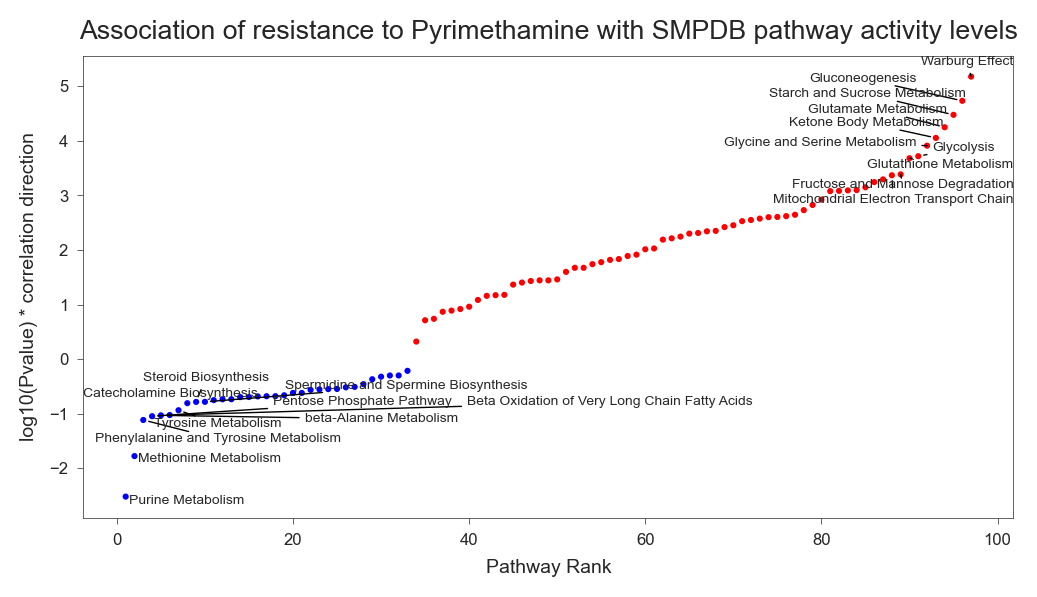

In [8]:
plot_pathwayrank('Pyrimethamine', metabolomic_drug_association_df)

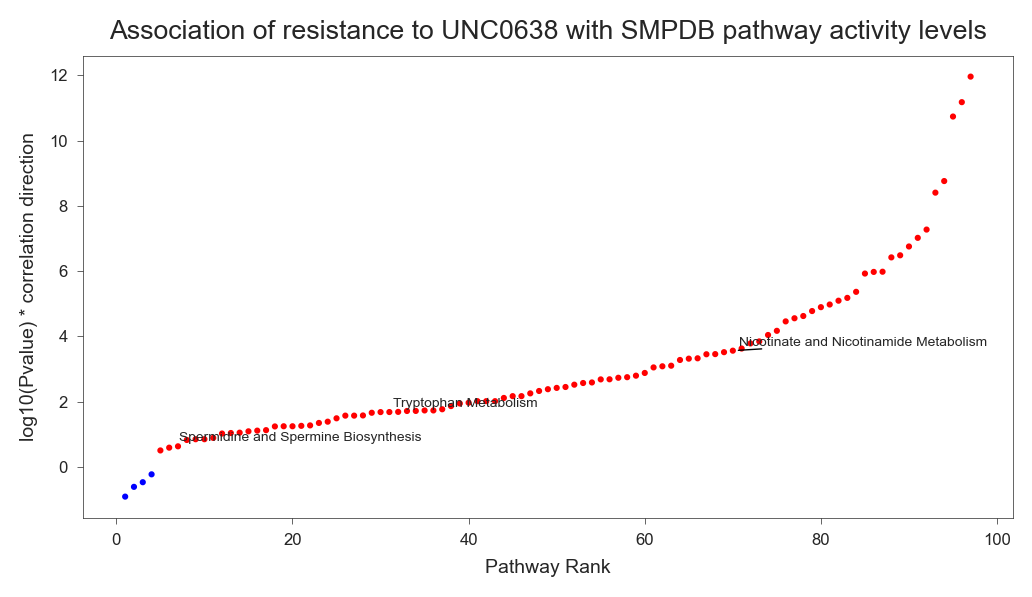

In [13]:
plot_pathwayrank('UNC0638', metabolomic_drug_association_df)

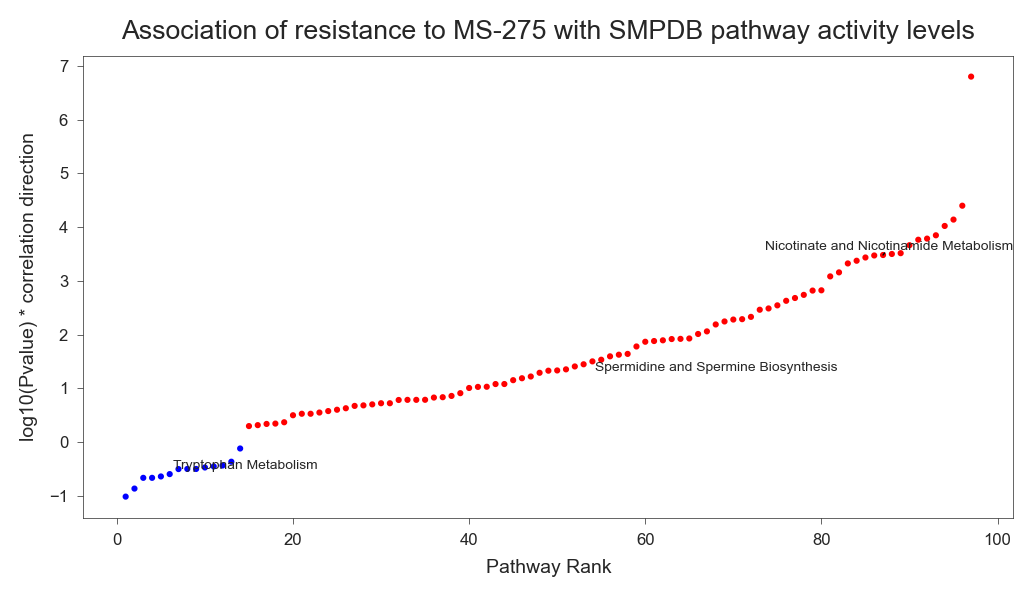

In [14]:
plot_pathwayrank('MS-275', metabolomic_drug_association_df)

### Plot drug rank

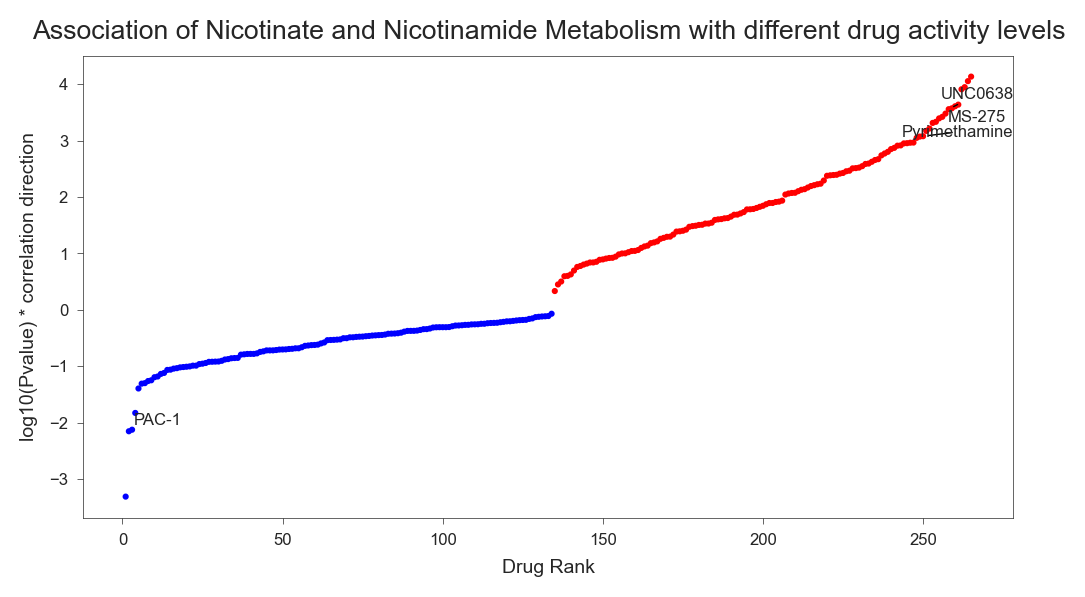

In [14]:
plot_drug_rank('Nicotinate and Nicotinamide Metabolism', metabolomic_drug_association_df)
plt.savefig('./Nicotinate and Nicotinamide Metabolism.pdf', bbox_inches='tight')

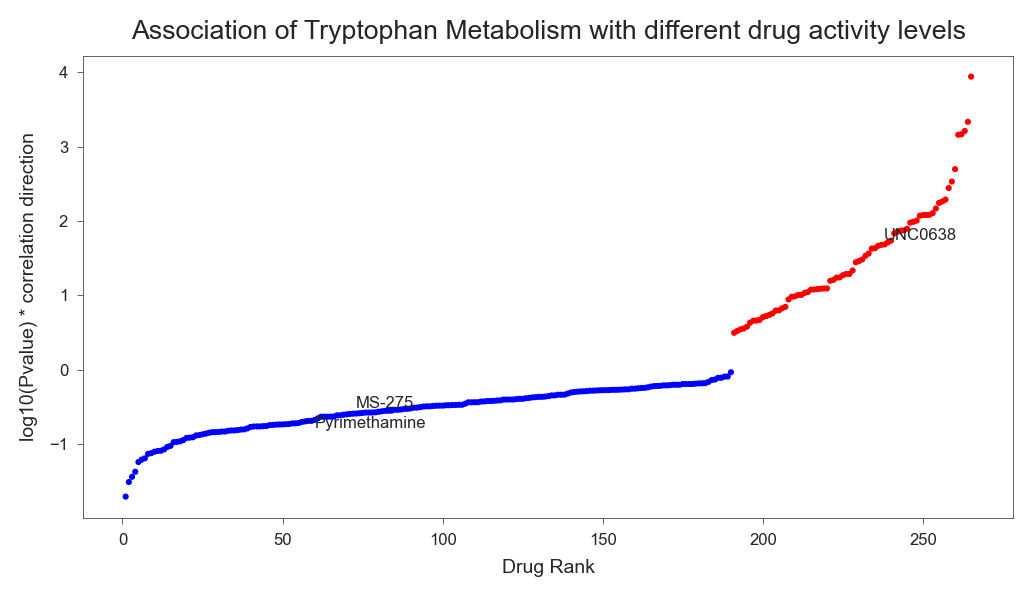

In [14]:
plot_drug_rank('Tryptophan Metabolism', metabolomic_drug_association_df)

# correlation

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
pathway_score_df = pd.read_csv("../data/clines/external_metabolomics/Pathway_scores_heatmap_ordered_values.csv", index_col=0).T

pathway_score_2_df = pd.read_csv(
    "../data/clines/external_metabolomics/PrimaryAnalysis/PathwayScore_180CCL.csv",
    index_col=0,
)

In [9]:
metabolomics_df = pd.read_csv("../data/clines/metabolomics.csv", index_col=0).T
model_list_df = pd.read_csv("../data/clines/model_list_20230505.csv", index_col=0)
depmap_model_df = pd.read_csv("../data/clines/depmap23Q2/Model.csv", index_col=0)

sanger_to_cell_line_name = depmap_model_df.set_index("SangerModelID").to_dict()[
    "CellLineName"
]
sanger_to_name = model_list_df.to_dict()["model_name"]
sanger_to_name.update(
    depmap_model_df.set_index("SangerModelID").to_dict()["CellLineName"]
)

In [10]:
metabolomics_df.index = metabolomics_df.index.map(sanger_to_cell_line_name)

In [12]:
metabolomics_df = metabolomics_df[metabolomics_df.index.notnull()]

In [32]:
metabolomics_df = metabolomics_df.fillna(metabolomics_df.mean())

In [33]:
from scipy.stats import zscore
def row_zscore(row):
    return (row - row.mean()) / row.std(ddof=0)


pathway_score_row_zscore = pd.DataFrame(
    pathway_score_df.apply(lambda row: zscore(row), axis=1),
    index=pathway_score_df.index,
)
metabolomics_row_zscore_df = pd.DataFrame(metabolomics_df.apply(lambda row: zscore(row), axis=1), index=metabolomics_df.index)
pathway_score_col_zscore = pd.DataFrame(
    pathway_score_df.apply(lambda col: zscore(col), axis=0),
    columns=pathway_score_df.columns,
)
metabolomics_col_zscore_df = pd.DataFrame(metabolomics_df.apply(lambda col: zscore(col), axis=0), columns=metabolomics_df.columns)

In [52]:
merged_df = pd.merge(
    metabolomics_row_zscore_df[["1-methylnicotinamide"]],
    pathway_score_df,
    left_index=True,
    right_index=True,
)
# merged_df = pd.DataFrame(StandardScaler().fit_transform(merged_df), columns=merged_df.columns, index=merged_df.index)
merged_corr_df = merged_df.corr()
merged_corr_df["Nicotinate and Nicotinamide Metabolism"].head(1)

1-methylnicotinamide    0.041119
Name: Nicotinate and Nicotinamide Metabolism, dtype: float64

In [43]:
merged_df = pd.merge(
    metabolomics_row_zscore_df[["1-methylnicotinamide"]],
    pathway_score_df,
    left_index=True,
    right_index=True,
)
# merged_df = pd.DataFrame(StandardScaler().fit_transform(merged_df), columns=merged_df.columns, index=merged_df.index)
merged_corr_df = merged_df.corr()
merged_corr_df["Nicotinate and Nicotinamide Metabolism"].head(1)

1-methylnicotinamide                                 0.041119
Alpha Linolenic Acid and Linoleic Acid Metabolism   -0.247714
Taurine and Hypotaurine Metabolism                  -0.001430
Homocysteine Degradation                            -0.028814
Arachidonic Acid Metabolism                         -0.337533
Name: Nicotinate and Nicotinamide Metabolism, dtype: float64

<Axes: xlabel='1-methylnicotinamide', ylabel='Nicotinate and Nicotinamide Metabolism'>

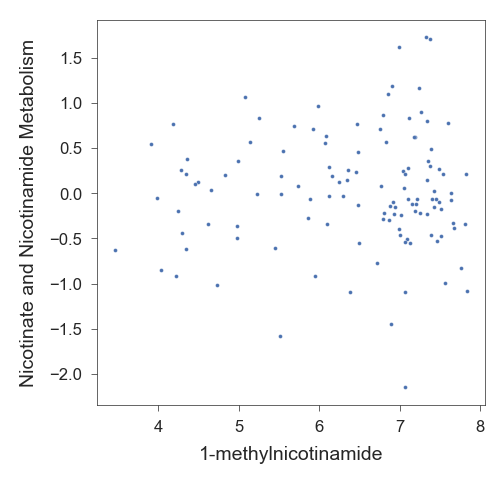

In [17]:
sns.scatterplot(
    x="1-methylnicotinamide",
    y="Nicotinate and Nicotinamide Metabolism",
    data=merged_df,
    s=2,
)

In [17]:
merged_corr_df[["1-methylnicotinamide"]].sort_values(by="1-methylnicotinamide")

,1-methylnicotinamide
Butyrate Metabolism,-0.262913
Purine Metabolism,-0.209182
D-Arginine and D-Ornithine Metabolism,-0.193213
Phosphatidylinositol Phosphate Metabolism,-0.187342
Steroid Biosynthesis,-0.186408
Glycine and Serine Metabolism,-0.184711
"Valine, Leucine, and Isoleucine Degradation",-0.184099
Ketone Body Metabolism,-0.181333
Taurine and Hypotaurine Metabolism,-0.179743
Lysine Degradation,-0.179055


In [20]:
merged_2_df = pd.merge(
    metabolomics_df[["1-methylnicotinamide"]],
    pathway_score_2_df,
    left_index=True,
    right_index=True,
)
merged_corr_2_df = merged_2_df.corr()

In [21]:
merged_corr_2_df[["1-methylnicotinamide"]].sort_values(by="1-methylnicotinamide")

,1-methylnicotinamide
Glycosylphosphatidylinositol (GPI)-anchor biosynthesis,-0.395012
Glycerophospholipid metabolism,-0.388946
Fatty acid degradation,-0.307353
Linoleic acid metabolism,-0.298331
alpha-Linolenic acid metabolism,-0.288860
Arachidonic acid metabolism,-0.282873
Taurine and hypotaurine metabolism,-0.279735
Arginine biosynthesis,-0.264512
Ascorbate and aldarate metabolism,-0.256880
"Valine, leucine and isoleucine degradation",-0.255801
